In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *

print(tf.__version__)

2.6.3


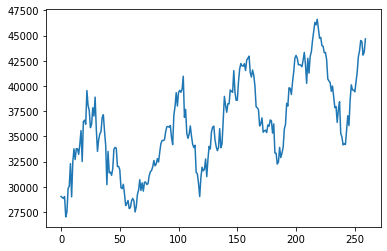

In [2]:
df = pd.read_excel('train.xlsx', parse_dates=True, dtype={'Product A (historical)': int})
df.drop(['Workweek'], axis=1, inplace=True)
df.columns = ['value']
data = df.values
plt.plot(data)

In [3]:
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def windowed_dataset(series, batch_size=32, n_past=26, n_future=1, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(-1)

batch_size = 16
n_past = 26
n_future = 1
shift = 1

scaler = MinMaxScaler(feature_range=(0, 1))  # scale between 0 and 1
scaler.fit(data)
scaled_data = scaler.transform(data)
SPLIT_TIME = 52*4  # take first 4 year as train, last year as val
x_train = scaled_data[:SPLIT_TIME]
x_val = scaled_data[SPLIT_TIME:]
train_set = windowed_dataset(series=x_train, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)
valid_set = windowed_dataset(series=x_val, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)


In [22]:
xIn = Input(shape=(None, 1))  # take in arbitrary number of time steps and 1 feature
x = tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding="causal", activation="relu")(xIn)
x = LSTM(64, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.1)(x)
x = LSTM(32, return_sequences=True)(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)
xOut = Dense(n_future)(x)

model = Model(inputs=xIn, outputs=xOut)
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=25, verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=40, verbose=1, restore_best_weights=True)]

opt = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='mae', optimizer=opt, metrics=['mae'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
model.fit(train_set, epochs=1000, validation_data=valid_set, callbacks=callbacks, verbose=1, use_multiprocessing=True, workers=16)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          96        
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 64)          20736     
_________________________________________________________________
layer_normalization_17 (Laye (None, None, 64)          128       
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, None, 64)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 32)          12416     
_________________________________________________________________
layer_normalization_18 (Laye (None, None, 32)          64  

1040.1976


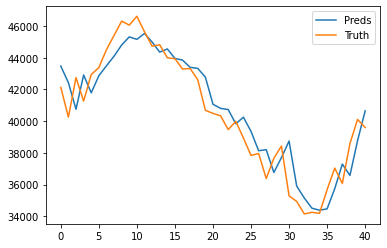

In [33]:
def model_forecast(models, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(tf.squeeze(series))
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = []
   for model in models:
    forecast += [model.predict(ds)]
   return np.mean(forecast, axis=0)

models = [load_model('model_1040_good_line')]
models += [load_model('model_1015')]
#models += [load_model('model_1116_good_line')]
preds = model_forecast(models, scaled_data, n_past, batch_size)
preds = scaler.inverse_transform(preds)
preds = preds[SPLIT_TIME - n_past:-1, 0]

x_valid = scaler.inverse_transform(x_val)
x_valid = np.squeeze(x_valid[:preds.shape[0]])
result = tf.keras.metrics.mean_absolute_error(x_valid, preds).numpy()
print(result)

'''
960.77594 (didnt save)
1015.6262
1040.1976 (good line)
1116.5305 (good line)
1155.5602 (good line)
'''

plt.plot(preds, label='Preds')
plt.plot(x_valid, label='Truth')
plt.legend()
plt.show()

In [13]:
model.save('model_1040_good_line')

INFO:tensorflow:Assets written to: model_1040_good_line\assets


INFO:tensorflow:Assets written to: model_1040_good_line\assets
